<a href="https://colab.research.google.com/github/edgarmariorivera-searce/llm/blob/main/%5BJT%5D_create_searchable_index_of_documents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this notebook is to demonstrate how to make various source document formats searchable in a vector DB index
* LangChain doc loaders for `pdf`, `powerpoint`,

* see [this example](https://www.patterns.app/blog/2023/01/18/crunchbot-sql-analyst-gpt) for creating SQL bot

## authenticate

In [ ]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

### pip and package

In [ ]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 174 kB of archives.
After this operation, 754 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 poppler-utils amd64 0.86.1-0ubuntu1.1 [174 kB]
Fetched 174 kB in 1s (129 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 122519 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.86.1-0ubuntu1.1_amd64.deb ...
Unpacking poppler-utils (0.86.1-0ubuntu1.1) ...
Setting up poppler-utils (0.86.1-0ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...


In [ ]:
# copy private-preview SDK locally
! gsutil cp gs://vertex_sdk_llm_private_releases/SDK/google_cloud_aiplatform-1.23.0.llm.alpha.23.03.28-py2.py3-none-any.whl .

Copying gs://vertex_sdk_llm_private_releases/SDK/google_cloud_aiplatform-1.23.0.llm.alpha.23.03.28-py2.py3-none-any.whl...
- [1 files][  2.4 MiB/  2.4 MiB]                                                
Operation completed over 1 objects/2.4 MiB.                                      


In [ ]:
!pip install -q  google-cloud-core
!pip install -q google_cloud_aiplatform-1.23.0.llm.alpha.23.03.28-py2.py3-none-any.whl "shapely<2.0.0"
!pip install -q --upgrade --user google-cloud-storage gcsfs google-cloud-documentai google-cloud-videointelligence
!pip install -q langchain chromadb pypdf PyPDF2 invoke pdf2image pikepdf pycryptodome unstructured youtube-transcript-api poppler-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.2/236.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.4/229.4 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 834.2/834.2 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
! python3 -c "import google.cloud.aiplatform; print('aiplatform SDK version: {}'.format(google.cloud.aiplatform.__version__))"
! python3 -c "import google.cloud.storage; print('storage SDK version: {}'.format(google.cloud.storage.__version__))"
! python3 -c "import gcsfs; print('gcsfs SDK version: {}'.format(gcsfs.__version__))"
! python3 -c "import langchain; print('langchain SDK version: {}'.format(langchain.__version__))"
! python3 -c "from google.cloud import documentai; print('documentai SDK version: {}'.format(documentai.__version__))"

aiplatform SDK version: 1.23.0
storage SDK version: 2.9.0
gcsfs SDK version: 2023.5.0
langchain SDK version: 0.0.170
documentai SDK version: 2.15.0


## Notebook setup

In [ ]:
PROJECT_ID='cpg-cdp'
LOCATION = 'us-central1'
#PROJECT_NUM=939655404703

! gcloud config set project $PROJECT_ID
! gcloud projects describe $PROJECT_ID --format="value(projectNumber)"

Are you sure you wish to set property [core/project] to gpc-d-specialproject?

Do you want to continue (Y/n)?  y

Updated property [core/project].
ERROR: (gcloud.projects.describe) User [arnasgenuineextra@gmail.com] does not have permission to access projects instance [gpc-d-specialproject] (or it may not exist): The caller does not have permission


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATA_DIR = '/content/drive/My Drive/Colab Notebooks/llm-demos'

Mounted at /content/drive


# Vertex LLM - PaLM

In [ ]:
import time

# google cloud & vertex
from google.cloud import storage
from google.cloud import aiplatform as vertex_ai
from google.cloud.aiplatform.private_preview import language_models
from google.cloud.aiplatform.private_preview.language_models import TextGenerationModel
from google.cloud.aiplatform.private_preview.language_models import TextEmbeddingModel

# langchain
from langchain.embeddings.base import Embeddings
from langchain.llms.base import LLM

storage_client = storage.Client(project=PROJECT_ID)

vertex_ai.init(project=PROJECT_ID,location=LOCATION)

from google.cloud.aiplatform.constants import base as constants

# # prod
constants.API_BASE_PATH = 'aiplatform.googleapis.com'
constants.PREDICTION_API_BASE_PATH = 'aiplatform.googleapis.com'

In [ ]:
### LLM class
def rate_limit(max_per_minute):
  period = 60 / max_per_minute
  while True:
    before = time.time()
    yield
    after = time.time()
    elapsed = after - before
    sleep_time = max(0, period - elapsed)
    if sleep_time > 0:
      print(f'Sleeping {sleep_time:.1f} seconds')
      time.sleep(sleep_time)


class VertexEmbeddings(Embeddings):

  def __init__(self, model, *, requests_per_minute=15):
    self.model = model
    self.requests_per_minute = requests_per_minute

  def embed_documents(self, texts):
    limiter = rate_limit(self.requests_per_minute)
    results = []
    docs = list(texts)

    while docs:
      # Working in batches of 2 because the API apparently won't let
      # us send more than 2 documents per request to get embeddings.
      head, docs = docs[:2], docs[2:]
      chunk = self.model.get_embeddings(head)
      results.extend(chunk)
      next(limiter)

    return [r.values for r in results]

  def embed_query(self, text):
    single_result = self.embed_documents([text])
    return single_result[0]

class VertexLLM(LLM):

  model: language_models.Any
  predict_kwargs: dict

  def __init__(self, model, **predict_kwargs):
    super().__init__(model=model, predict_kwargs=predict_kwargs)

  @property
  def _llm_type(self):
    return 'vertex'

  def _call(self, prompt, stop=None):
    result = self.model.predict(prompt, **self.predict_kwargs)
    return str(result)


  @property
  def _identifying_params(self):
    return {}

In [ ]:
REQUESTS_PER_MINUTE = 15
#REQUESTS_PER_MINUTE = 6000

model = language_models.TextGenerationModel.from_pretrained('text-bison-001')

llm = VertexLLM(
  model,
  max_output_tokens=256,
  temperature=0.1,
  top_p=0.8,
  top_k=40,
  # verbose=True,
)
embedding = VertexEmbeddings(language_models.TextEmbeddingModel(), requests_per_minute=REQUESTS_PER_MINUTE)

## LangChain document loaders

In [ ]:
import os
import time
import io
import pandas as pd
from IPython.display import display, Image, Markdown
from PIL import Image, ImageDraw
from traitlets.traitlets import Dict

# langchain doc loaders
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import OnlinePDFLoader
from langchain.document_loaders import UnstructuredPowerPointLoader
from langchain.document_loaders import UnstructuredWordDocumentLoader

# langchain vector DB
from langchain.indexes import VectorstoreIndexCreator
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from langchain.vectorstores.chroma import Chroma

# langhcain utils
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders.base import BaseLoader

# pdfs
from PyPDF2 import PdfReader, PdfWriter
from pdf2image import convert_from_path, convert_from_bytes
from pikepdf import Pdf

# DocAI
# from google.cloud import documentai_v1beta3 as documentai
from google.cloud import documentai_v1 as documentai
from google.api_core.client_options import ClientOptions

# youtube API
from youtube_transcript_api import YouTubeTranscriptApi

### PDFs

PATH_TO_PDF: /content/drive/My Drive/Colab Notebooks/llm-demos/NASDAQ_GOOG_2022.pdf


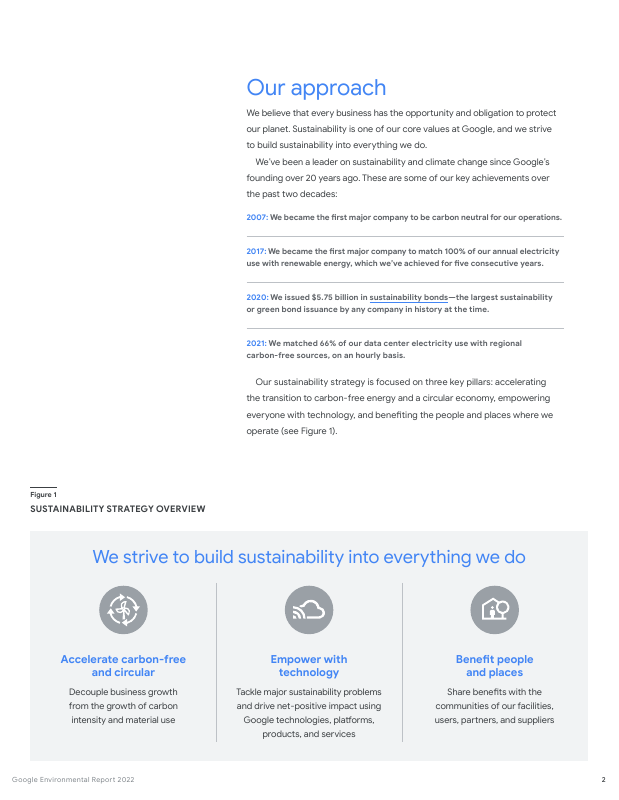

In [ ]:
ESG_PDF_FILE = 'NASDAQ_GOOG_2022.pdf'
PATH_TO_PDF = f'{DATA_DIR}/{ESG_PDF_FILE}'
print(f"PATH_TO_PDF: {PATH_TO_PDF}")

images = convert_from_bytes(open(f'{PATH_TO_PDF}', 'rb').read(), size=800)
display(images[2])

PATH_TO_ESCALADE_PDF: /content/drive/My Drive/Colab Notebooks/llm-demos/escalade_manual.pdf


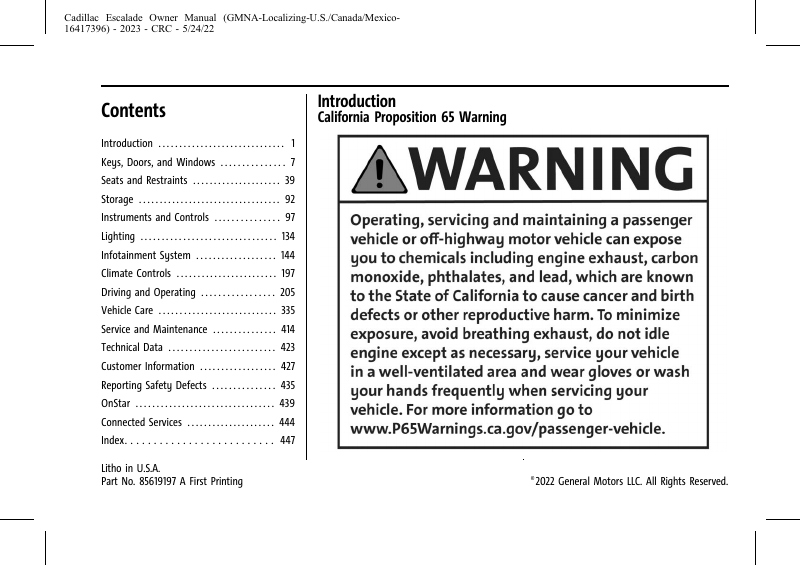

In [ ]:
ESCALADE_PDF_FILE='escalade_manual.pdf'
PATH_TO_ESCALADE_PDF = f'{DATA_DIR}/{ESCALADE_PDF_FILE}'
print(f"PATH_TO_ESCALADE_PDF: {PATH_TO_ESCALADE_PDF}")

images = convert_from_bytes(open(f'{PATH_TO_ESCALADE_PDF}', 'rb').read(), size=800)
display(images[2])

### PowerPoint (`.pptx`)

In [ ]:
PPTX_FILE = 'NDR-slides.pptx'
PATH_TO_PPTX = f'{DATA_DIR}/{PPTX_FILE}'
print(f"PATH_TO_PPTX: {PATH_TO_PPTX}")

PATH_TO_PPTX: /content/drive/My Drive/Colab Notebooks/llm-demos/NDR-slides.pptx


### Word doc

In [ ]:
WORD_FILE ='scaling-deep-retrieval-blog-draft.docx'
PATH_TO_WORD = f'{DATA_DIR}/{WORD_FILE}'
print(f"PATH_TO_WORD: {PATH_TO_WORD}")

PATH_TO_WORD: /content/drive/My Drive/Colab Notebooks/llm-demos/scaling-deep-retrieval-blog-draft.docx


### YouTube Video transcription

* [Time to winterize - 10 tips to prepare your vehicle for Winter](https://www.youtube.com/watch?v=rPq8UsaiR1I)

In [ ]:
YOUTUBE_URL='rPq8UsaiR1I'

video_transcript = YouTubeTranscriptApi.get_transcript(YOUTUBE_URL)

merged_text = " ".join([t['text'] for t in video_transcript]).replace("\n", " ")

In [ ]:
class PageContentLoader(BaseLoader):
  def __init__(self, content: str, metadata = {}):
    """Initialize with file path."""
    self.content = content
    self.metadata = metadata

  def load(self):
    return [
        Document(
            page_content=self.content, metadata=self.metadata
        )
    ]

# Create Vector Database

In [ ]:
INDEX_PATH = f'{DATA_DIR}/multi_index_v2'

# Check to see if we built an index already.
index = None

if os.path.isdir(INDEX_PATH):
  vectorstore = Chroma(embedding_function=embedding, persist_directory=INDEX_PATH)
  index = VectorStoreIndexWrapper(vectorstore=vectorstore)

else:
  loaders = [
      PyPDFLoader(f'{PATH_TO_PDF}'),
      PyPDFLoader(f'{PATH_TO_ESCALADE_PDF}'),
      UnstructuredPowerPointLoader(PATH_TO_PPTX),
      UnstructuredWordDocumentLoader(PATH_TO_WORD),
      PageContentLoader(merged_text),
  ]
  index = VectorstoreIndexCreator(
      embedding=embedding, vectorstore_kwargs={
          'persist_directory': INDEX_PATH,
      }
  ).from_loaders(loaders)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Sleeping 3.9 seconds
Sleeping 3.8 seconds
Sleeping 3.8 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.8 seconds
Sleeping 3.8 seconds
Sleeping 3.8 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.8 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.8 seconds
Sleeping 3.8 seconds
Sleeping 3.9 seconds
Sleeping 3.8 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.8 seconds
Sleeping 3.8 seconds
Sleeping 3.8 seconds
Sleeping 3.8 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 seconds
Sleeping 3.9 

## Interact with indexed docs (Q&A)

In [ ]:
queries = [
    "(1) how would I know if my coolant cap has been venting?", # 1:40
    "(2) How many volts should the battery have?", # 2:57
    "(3) How do I know if I have rear differential?", # 7:03
    "(4) What are some of Google's key achievements in the past two decades?",
    "(5) How long has Google been carbon neutral?",
    "(6) How many EV charging ports does Google have across its offices?",
    "(7) What is the candidate generation stage?",
    "(8) What are the benefits to using TensorFlow Recommenders?",
    "(9) What are the benefits of using Vertex AI Matching Engine?",
    "(10) What is neural deep retreival?",
    "(11) What is a two-tower model and why is it good for information retrieval?",
    "(12) What is a distributed search tree?",
]

for q in queries:
  prompt = f'Please answer using 3 to 4 sentences: {q}'
  print(f'{q}: {index.query(prompt, llm=llm)}')

(1) how would I know if my coolant cap has been venting?: If you see any coolant crusties that look like they're coming around the metal area, that means that your cap's been venting.
(2) How many volts should the battery have?: The battery should have at least 12 volts, preferably 12.4.
(3) How do I know if I have rear differential?: If you have a rear differential, you will have a drive shaft running from the transmission to the rear differential. The drive shaft will have two u-joints in it.
(4) What are some of Google's key achievements in the past two decades?: We became the first major company to be carbon neutral for our operations.
(5) How long has Google been carbon neutral?: Google has been carbon neutral since 2007.
(6) How many EV charging ports does Google have across its offices?: Google has nearly 4,000 EV charging ports at its offices in the United States and Canada.
(7) What is the candidate generation stage?: The retrieval stage is responsible for selecting an initial